In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from helper import get_performance

EPOCHS = 700
BATCH_SIZE = 2048
ACTIVATION = 'swish'
LEARNING_RATE = 0.0007
FOLDS = 5

In [26]:
# Reading the dataset
raw_train = pd.read_csv("dataset/tabular/train.csv")
#raw_train = raw_train.sample(frac=0.01, replace=True, random_state=1)
target = raw_train.target
X_train, X_test, y_train, y_test = train_test_split(raw_train, target, test_size = 0.5, random_state = 29)

X_train = X_train.sample(frac=0.03, replace=True, random_state=1).reset_index(drop=True)
target = X_train.target
X_train = X_train.drop('target', axis = 1)
train = X_train.drop('id', axis = 1)

X_test = X_test.sample(frac=0.03, replace=True, random_state=1).reset_index(drop=True)
y_test = X_test.target
X_test = X_test.drop('target', axis = 1)
test = X_test.drop('id', axis = 1)

print("Train data: ", train.shape)
print("Test data: ", test.shape)

Train data:  (9000, 100)
Test data:  (9000, 100)


In [27]:
X_test = test

In [28]:
target.value_counts()

0    4505
1    4495
Name: target, dtype: int64

In [29]:
y_test.value_counts()

1    4582
0    4418
Name: target, dtype: int64

# Default Model

In [30]:
model_default = DecisionTreeClassifier()
scores_default = cross_val_score(model_default, X=train, y=target, cv = FOLDS)
model_default.fit(train, target)
y_pred_default = model_default.predict(X_test)
get_performance(X_test, y_test, y_pred_default)

Performance on all data
Precision: 0.5476613421697138
Recall: 0.5475555555555556
F1 Score: 0.5475887397719632


(0.5476613421697138, 0.5475555555555556, 0.5475887397719632, None)

In [31]:
pd.DataFrame(y_pred_default).value_counts()

1    4528
0    4472
dtype: int64

# SMOTE Oversampling

In [32]:
# SMOTE Oversampling
    # Transform data 
oversample = SMOTE()
X_train_sm, y_train_sm = oversample.fit_resample(train, target)
model_SMOTE = DecisionTreeClassifier()
scores_SMOTE = cross_val_score(model_SMOTE, X=X_train_sm, y=y_train_sm, cv = FOLDS)
model_SMOTE.fit(X_train_sm, y_train_sm)
y_pred_SMOTE = model_SMOTE.predict(X_test)
get_performance(X_test, y_test, y_pred_SMOTE)

Performance on all data
Precision: 0.5445574026231412
Recall: 0.5445555555555556
F1 Score: 0.5445564723679411


(0.5445574026231412, 0.5445555555555556, 0.5445564723679411, None)

In [33]:
print(X_train_sm.shape,y_train_sm.shape)

(9010, 100) (9010,)


# MAPS

In [34]:
import time 
import sys
sys.path.insert(1, './mmd')
from mmd import diagnoser
from scipy import stats as st
import numpy
#notebook's library
%matplotlib inline
from helper import get_top_f1_rules, get_relevent_attributs_target, get_MMD_results, get_biased_features, get_BGMD_results
from helper import generateTrain_data_Weights

In [35]:
default_result = pd.concat([X_test, y_test], axis=1, join='inner')
default_result.loc[:,"pred"] = y_pred_default

In [36]:
def mispredict_label(row):
    if row['target'] == row['pred']:
        return False
    return True

In [37]:
default_result_copy = default_result.copy()
X_test_copy = X_test.copy()
X_test_copy['mispredict'] = default_result_copy.apply(lambda row: mispredict_label(row), axis=1)

In [38]:
# Get relevent attributes and target 
relevant_attributes, Target = get_relevent_attributs_target(X_test_copy)
# Generate MMD rules and correspodning information
MMD_rules, MMD_time, MMD_Features = get_MMD_results(X_test_copy, relevant_attributes, Target)

#Get biased attributes this time 
biased_attributes = get_biased_features(X_test_copy, relevant_attributes)

BGMD_rules, BGMD_time, BGMD_Features = get_BGMD_results(X_test_copy, biased_attributes, Target)

print('MMD Spent:', MMD_time, 'BGMD Spent:', BGMD_time)
MMD_rules, BGMD_rules

MMD Spent: 89.63606882095337 BGMD Spent: 3.569439649581909


([[0.5298153034300792, 'f2<=172.454'],
  [0.44140268543866507, 'f16<=0.0250106']],
 [[0.4385919165580182, 'f34<=1.90474'],
  [0.28995394849053385, 'f34<=0.920038'],
  [0.08525033829499325, 'f57>4.08037 & f34<=0.920038']])

In [39]:
from helper import get_test_data_in_misprediction_areas

final_result = pd.concat([X_test, y_test], axis=1, join='inner')

indexes_in_misprediction_area = get_test_data_in_misprediction_areas(BGMD_rules, X_test)
y_actual_MD = []

for index in indexes_in_misprediction_area:
        y_actual_MD.append(final_result.loc[index]['target'])

In [40]:
from collections import Counter
from sklearn.metrics import precision_recall_fscore_support
grid_upweights = range(1, 101)
best_weight_all = 1
best_f1_all = 0
best_weight_mis = 1
best_f1_mis = 0
f1_all = []
f1_mispredicted = []
acc_all = []
acc_mispredicted = []
recall_all = []
recall_mispredicted = []
for upweight in grid_upweights:
    # give extra weights to training samples in mispredited areas 
    print('Upweight_value: ', upweight)
    weights = generateTrain_data_Weights(BGMD_rules, train, upweight_value=upweight)

    c = Counter(weights)
    print(c.items())

    MAPS_model = DecisionTreeClassifier()
    scores_MAPS = cross_val_score(MAPS_model, X=train, y=target, cv = FOLDS)
    MAPS_model.fit(train, target, sample_weight = weights)

    y_pred_MAPS = MAPS_model.predict(X_test)

    total_result = get_performance(X_test, y_test, y_pred_MAPS)
    
    acc_all.append(total_result[0])
    recall_all.append(total_result[1])
    f1_all.append(total_result[2])
    
    final_result['y_pred_MAPS'] = y_pred_MAPS
    y_pred_MAPS_MD = []
    for index in indexes_in_misprediction_area:
        y_pred_MAPS_MD.append(final_result.loc[index]['y_pred_MAPS'])
    MAPS_MD_metric = precision_recall_fscore_support(y_actual_MD, y_pred_MAPS_MD, average='weighted')
    acc_mispredicted.append(MAPS_MD_metric[0])
    recall_mispredicted.append(MAPS_MD_metric[1])
    f1_mispredicted.append(MAPS_MD_metric[2])
    
    if total_result[2] > best_f1_all:
        best_f1_all = total_result[2]
        best_weight_all = upweight;
    if MAPS_MD_metric[2] > best_f1_mis:
        best_f1_mis = MAPS_MD_metric[2]
        best_weight_mis = upweight

Upweight_value:  1
dict_items([(1, 9000)])
Performance on all data
Precision: 0.5390637081463338
Recall: 0.539
F1 Score: 0.5390246089544971
Upweight_value:  2
dict_items([(1, 5448), (2, 3552)])
Performance on all data
Precision: 0.5343414757721178
Recall: 0.5342222222222223
F1 Score: 0.5342581091541531
Upweight_value:  3
dict_items([(1, 5448), (3, 3552)])
Performance on all data
Precision: 0.5423150488118486
Recall: 0.542
F1 Score: 0.5420148596149941
Upweight_value:  4
dict_items([(1, 5448), (4, 3552)])
Performance on all data
Precision: 0.5374565805415087
Recall: 0.5373333333333333
F1 Score: 0.5373694602452393
Upweight_value:  5
dict_items([(1, 5448), (5, 3552)])
Performance on all data
Precision: 0.5306219018776707
Recall: 0.5306666666666666
F1 Score: 0.5306405116490995
Upweight_value:  6
dict_items([(1, 5448), (6, 3552)])
Performance on all data
Precision: 0.528495049065925
Recall: 0.5284444444444445
F1 Score: 0.528465337521248
Upweight_value:  7
dict_items([(1, 5448), (7, 3552)])
P

dict_items([(1, 5448), (51, 3552)])
Performance on all data
Precision: 0.5355389464996871
Recall: 0.5353333333333333
F1 Score: 0.5353700495932897
Upweight_value:  52
dict_items([(1, 5448), (52, 3552)])
Performance on all data
Precision: 0.5288326913580247
Recall: 0.5286666666666666
F1 Score: 0.5287057964005144
Upweight_value:  53
dict_items([(1, 5448), (53, 3552)])
Performance on all data
Precision: 0.5310209053249999
Recall: 0.5307777777777778
F1 Score: 0.5308096336218463
Upweight_value:  54
dict_items([(1, 5448), (54, 3552)])
Performance on all data
Precision: 0.5350882392987456
Recall: 0.535
F1 Score: 0.5350307470420849
Upweight_value:  55
dict_items([(1, 5448), (55, 3552)])
Performance on all data
Precision: 0.531711120151897
Recall: 0.5316666666666666
F1 Score: 0.5316854219490589
Upweight_value:  56
dict_items([(1, 5448), (56, 3552)])
Performance on all data
Precision: 0.5356301256316136
Recall: 0.5354444444444444
F1 Score: 0.5354825462419757
Upweight_value:  57
dict_items([(1, 54

Best weight on all is:  24
Best weight on misprediction area is:  12


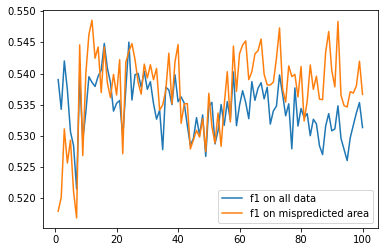

In [41]:
print("Best weight on all is: ", best_weight_all)
print("Best weight on misprediction area is: ", best_weight_mis)
plt.plot(grid_upweights, f1_all, label = "f1 on all data")
plt.plot(grid_upweights, f1_mispredicted, label = "f1 on mispredicted area")
plt.legend()
plt.show()

In [42]:
from helper import get_mispredicted_region_test

weights = generateTrain_data_Weights(BGMD_rules, X_train, upweight_value=best_weight_mis)
c = Counter(weights)
MAPS_model = DecisionTreeClassifier()
scores_MAPS = cross_val_score(MAPS_model, X=train, y=target, cv = FOLDS)
MAPS_model.fit(train, target, sample_weight = weights)
y_pred_MAPS = MAPS_model.predict(X_test)
get_performance(X_test, y_test, y_pred_MAPS)

default_MD_metric, SMOTE_MD_metric, MAPS_MD_metric = get_mispredicted_region_test(X_test, y_test, y_pred_default, y_pred_SMOTE, y_pred_MAPS, BGMD_rules, ylabel='target')

Performance on all data
Precision: 0.5342451044669794
Recall: 0.5342222222222223
F1 Score: 0.5342327138403088
y_actual_MD: 3598
y_predict_default_MD: 3598
y_pred_SMOTE_MD: 3598
y_pred_MAPS_MD: 3598

Default: (0.5332633754788284, 0.5325180655919955, 0.5328672731931487, None)
SMOTE: (0.5293664371138588, 0.5297387437465259, 0.529546764988837, None)
MAPS: (0.5386913075456028, 0.5383546414674819, 0.538517993619674, None)


In [43]:
dict = {'acc_all': acc_all, 'recall_all': recall_all, 'f1_all': f1_all, 'acc_mispredicted': acc_mispredicted, 'recall_mispredicted': recall_mispredicted, 'f1_mispredicted': f1_mispredicted}
out = pd.DataFrame(dict)
out.to_csv('MAPS_Kaggle_Nov_Results.csv')

# Just Train Twice

In [44]:
from helper import generate_JTT_Weights

In [45]:
X_train_1st, X_val, y_train_1st, y_val = train_test_split(train, target, test_size = 0.33, random_state = 29)

model_JTT = DecisionTreeClassifier()
scores_JTT_1st = cross_val_score(model_JTT, X_train_1st, y=y_train_1st, cv = FOLDS)
model_JTT.fit(X_train_1st, y_train_1st)
y_pred_JTT_val = model_JTT.predict(X_val)
get_performance(X_val, y_val, y_pred_JTT_val)

Performance on all data
Precision: 0.5613348537598575
Recall: 0.5612794612794613
F1 Score: 0.5612841862586928


(0.5613348537598575, 0.5612794612794613, 0.5612841862586928, None)

In [46]:
grid_upweights_JTT = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
best_weight_all_JTT = 1
best_f1_all_JTT = 0
f1_all_JTT = [];

for upweight in grid_upweights_JTT:
    weights = generate_JTT_Weights(y_val.to_list(), y_pred_JTT_val, weight = upweight)
    
    #combine train and validate data
    weights = np.concatenate((np.ones(len(X_train_1st)), weights))
    y_train_2nd = np.concatenate((y_train_1st, y_val))
    X_train_2nd = pd.concat([X_train_1st, X_val])
    X_train_2nd['val_weight'] = weights
    X_train_2nd['target'] = y_train_2nd
    X_train_2nd = X_train_2nd.sample(frac=1, random_state=1).reset_index(drop=True)
    weights = X_train_2nd['val_weight'].to_list()
    y_train_2nd = X_train_2nd['target']
    X_train_2nd = X_train_2nd.drop(['val_weight', 'target'], axis=1)
    
    model_JTT = DecisionTreeClassifier()
    scores_JTT_2nd = cross_val_score(model_JTT, X_train_2nd, y=y_train_2nd, cv = FOLDS)
    model_JTT.fit(X_train_2nd, y_train_2nd, sample_weight = weights)
    y_pred_JTT = model_JTT.predict(X_test)
    total_result_JTT = get_performance(X_test, y_test, y_pred_JTT)
    f1_all_JTT.append(total_result_JTT[2])
    if total_result_JTT[2] > best_f1_all_JTT:
        best_f1_all_JTT = total_result_JTT[2]
        best_weight_all_JTT = upweight;

Performance on all data
Precision: 0.5412878599307923
Recall: 0.541
F1 Score: 0.5410221852303431
Performance on all data
Precision: 0.544
Recall: 0.544
F1 Score: 0.544
Performance on all data
Precision: 0.5364629574878048
Recall: 0.5363333333333333
F1 Score: 0.5363701735317381
Performance on all data
Precision: 0.5328784827215202
Recall: 0.5327777777777778
F1 Score: 0.5328110250148228
Performance on all data
Precision: 0.5377794269370454
Recall: 0.5376666666666666
F1 Score: 0.5377014835755407
Performance on all data
Precision: 0.5419885091831718
Recall: 0.5417777777777778
F1 Score: 0.5418135547513582
Performance on all data
Precision: 0.53691790433517
Recall: 0.5366666666666666
F1 Score: 0.536696869857696
Performance on all data
Precision: 0.5345432370883657
Recall: 0.5342222222222223
F1 Score: 0.5342342979716072
Performance on all data
Precision: 0.5306897602928069
Recall: 0.5304444444444445
F1 Score: 0.5304759112856715
Performance on all data
Precision: 0.534836450416833
Recall: 0.53

JTT Best weight on all is:  20
JTT Best f1 score on all:  0.544


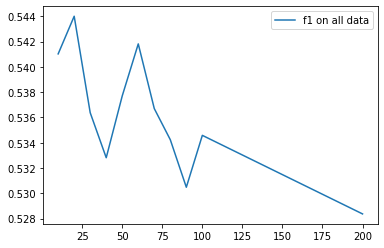

In [47]:
print("JTT Best weight on all is: ", best_weight_all_JTT)
print("JTT Best f1 score on all: ", best_f1_all_JTT)
plt.plot(grid_upweights_JTT, f1_all_JTT, label = "f1 on all data")
plt.legend()
plt.show()

In [48]:
weights = generate_JTT_Weights(y_val.to_list(), y_pred_JTT_val, weight = best_weight_all_JTT)
    
#combine train and validate data
weights = np.concatenate((np.ones(len(X_train_1st)), weights))
y_train_2nd = np.concatenate((y_train_1st, y_val))
X_train_2nd = pd.concat([X_train_1st, X_val])
X_train_2nd['val_weight'] = weights
X_train_2nd['target'] = y_train_2nd
X_train_2nd = X_train_2nd.sample(frac=1, random_state=1).reset_index(drop=True)
weights = X_train_2nd['val_weight'].to_list()
y_train_2nd = X_train_2nd['target']
X_train_2nd = X_train_2nd.drop(['val_weight', 'target'], axis=1)

model_JTT = DecisionTreeClassifier()
scores_JTT_2nd = cross_val_score(model_JTT, X_train_2nd, y=y_train_2nd, cv = FOLDS)
model_JTT.fit(X_train_2nd, y_train_2nd, sample_weight = weights)
y_pred_JTT = model_JTT.predict(X_test)
total_result_JTT = get_performance(X_test, y_test, y_pred_JTT)
    

default_MD_metric, SMOTE_MD_metric, MAPS_MD_metric = get_mispredicted_region_test(X_test, y_test, y_pred_JTT, y_pred_SMOTE, y_pred_MAPS, BGMD_rules, ylabel='target')

Performance on all data
Precision: 0.5356952732550605
Recall: 0.5356666666666666
F1 Score: 0.5356794823397624
y_actual_MD: 3598
y_predict_default_MD: 3598
y_pred_SMOTE_MD: 3598
y_pred_MAPS_MD: 3598

Default: (0.5373335871317229, 0.5366870483602001, 0.5369922199272363, None)
SMOTE: (0.5293664371138588, 0.5297387437465259, 0.529546764988837, None)
MAPS: (0.5386913075456028, 0.5383546414674819, 0.538517993619674, None)
